# Introduction

데이터는 유저와 광고의 features로 되어 있음 (categorical, binary, numerical)  
유저가 광고를 보고 클릭은 안했지만, 다이렉트로 앱을 설치한 경우도 있음.  

train/test 데이터를 만들기 위해. 총 22일간 데이터가 있음.  
첫 21일 간의 데이터는 train으로 사용하고, 22번째 날이 test로 사용되는 것임.  
train에는 impression record가 있음. 이는 유저가 광고를 보면서 생기게 되는 것임.. (클릭과 무관하게 광고를 봄으로 인해서 생기는 feature인듯)  

is_clicked, is_installed는 binary하게 들어가고 4개의 조합이 생김.
뭐, 클릭하고 설치하고(1,1), 클릭 안하고 설치하고(0,1) 이런식으로  
데이터를 관리 가능한 사이즈로 유지하고, 클릭 수, 변환율과 같은 기밀 정보를 보호하기 위해 4개의 조합에 해당하는 레코드를 차등적으로 다운 샘플링함

**TASK**  
is_clicked, is_installed 이 label 이고 예측하는 거임.

**데이터 설명**  
train은 총 30개 파일로 쪼개져있음. test는 1개

**train 설명**  
각 row는 impression record임.  
각 파일은 다음과 같은 형식으로 이루어짐

1. 첫번째 행은 헤더. 80개의 feature와 2개의 label  
   a. f_0은 rowId  
   b. f_1은 Date  
   c. Categorical feature (f_2 ~ f_32) => 31개   
   d. Binary feature (f_33 ~ f_41)  => 9개  
   e. Numerical feature (f_42 ~ f_79)  => 38개  
2. feature 몇개는 nullable하다. 이는 빈 문자열로 표시됌.  

**test 설명**  
걍 label만 없음.

**제출 형태**  
RowId | is_clicked | is_installed

In [29]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 100

## Data Load

In [8]:
train_path = "./train"
test_path = "./test"

train_files = os.listdir(train_path)
test_files = os.listdir(test_path)

print(len(train_files), len(test_path))

30 6


In [9]:
def GetAllDataList(t="train"):
    total = []
    
    if t == "train":
        files = train_files
        path = train_path
    elif t == "test":
        files = test_files
        path = test_path
    else:
        return False
        
    for file_name in files:
        total.append(pd.read_csv(os.path.join(path, file_name), sep="\t"))
        
    return total

In [10]:
total_train = GetAllDataList(t="train")
total_test = GetAllDataList(t="test")

In [11]:
total_train[0]

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_72,f_73,f_74,f_75,f_76,f_77,f_78,f_79,is_clicked,is_installed
0,2541162,51,6581,22294,5491,25604,14597,27941,18800,31372,...,3.997850,1.713364,0.115692,1.156922,0.269948,0.0,0.0,0.0,0,0
1,2541260,49,20095,563,22861,15908,22651,27941,21218,869,...,0.000000,0.000000,0.115692,1.156922,0.269948,0.0,0.0,0.0,0,0
2,2541318,51,20095,563,22861,25604,22651,27941,21218,31372,...,0.000000,0.000000,0.038564,1.156922,0.269948,0.0,0.0,0.0,0,0
3,2541770,64,13658,22294,7003,25604,29975,27941,21218,21533,...,1.713364,1.142243,0.115692,1.156922,0.269948,0.0,0.0,0.0,0,0
4,2542002,62,20095,563,31686,15908,590,27941,18800,23218,...,0.000000,0.000000,0.115692,1.156922,0.269948,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116469,1988207,60,23611,22294,9727,25604,21295,27941,19203,14659,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1,0
116470,1989166,54,32683,22294,21079,21545,32375,27941,19203,9638,...,5.140093,1.142243,0.038564,1.156922,0.269948,0.0,0.0,0.0,0,1
116471,1989222,58,31824,22294,6036,29304,17541,27941,19203,31372,...,2.284486,0.571121,0.115692,1.156922,0.269948,0.0,0.0,0.0,1,1
116472,1989240,49,20095,563,22861,21545,22651,27941,19203,869,...,0.000000,0.000000,0.000000,1.156922,0.192820,0.0,0.0,0.0,0,1


In [13]:
categorical_cols = [f"f_{i}" for i in range(2, 33)]
binary_cols = [f"f_{i}" for i in range(33, 42)]
numerical_cols = [f"f_{i}" for i in range(42, 80)]

In [16]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

## train data missing data

In [19]:
missing_data(total_train[0][categorical_cols])

,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,f_31,f_32
Total,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,55451,55451,0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.60805,47.60805,0.0
Types,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int64


In [20]:
missing_data(total_train[0][binary_cols])

,f_33,f_34,f_35,f_36,f_37,f_38,f_39,f_40,f_41
Total,0,0,0,0,0,0,0,0,0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Types,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [21]:
missing_data(total_train[0][numerical_cols])

,f_42,f_43,f_44,f_45,f_46,f_47,f_48,f_49,f_50,f_51,f_52,f_53,f_54,f_55,f_56,f_57,f_58,f_59,f_60,f_61,f_62,f_63,f_64,f_65,f_66,f_67,f_68,f_69,f_70,f_71,f_72,f_73,f_74,f_75,f_76,f_77,f_78,f_79
Total,0,6064,0,0,0,0,0,0,0,6064,0,0,0,0,0,0,6064,6064,0,0,0,0,6064,6064,6064,6064,6064,6064,6064,0,0,0,0,0,0,0,0,0
Percent,0.0,5.206312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.206312,0.0,0.0,0.0,0.0,0.0,0.0,5.206312,5.206312,0.0,0.0,0.0,0.0,5.206312,5.206312,5.206312,5.206312,5.206312,5.206312,5.206312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Types,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


## test data missing data

In [22]:
missing_data(total_test[0][categorical_cols])

,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,f_31,f_32
Total,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43867,43867,0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.251154,27.251154,0.0
Types,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int64


In [23]:
missing_data(total_test[0][binary_cols])

,f_33,f_34,f_35,f_36,f_37,f_38,f_39,f_40,f_41
Total,0,0,0,0,0,0,0,0,0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Types,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [24]:
missing_data(total_test[0][numerical_cols])

,f_42,f_43,f_44,f_45,f_46,f_47,f_48,f_49,f_50,f_51,f_52,f_53,f_54,f_55,f_56,f_57,f_58,f_59,f_60,f_61,f_62,f_63,f_64,f_65,f_66,f_67,f_68,f_69,f_70,f_71,f_72,f_73,f_74,f_75,f_76,f_77,f_78,f_79
Total,0,9767,0,0,0,0,0,0,0,9767,0,0,0,0,0,0,9767,9767,0,0,0,0,9767,9767,9767,9767,9767,9767,9767,0,0,0,0,0,0,0,0,0
Percent,0.0,6.067477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.067477,0.0,0.0,0.0,0.0,0.0,0.0,6.067477,6.067477,0.0,0.0,0.0,0.0,6.067477,6.067477,6.067477,6.067477,6.067477,6.067477,6.067477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Types,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


## label 분석

* 0, 0 => 0
* 0, 1 => 1
* 1, 0 => 2
* 1, 1 => 3

In [31]:
label_cols = ["is_clicked", "is_installed"]

In [53]:
pd.pivot_table(total_train[0], index="is_clicked", columns="is_installed", values="f_1",aggfunc="count")

is_installed,0,1
is_clicked,,
0,78551,12078
1,17497,8348


In [57]:
def get_clean_label(row):
    is_clicked = row["is_clicked"]
    is_installed = row["is_installed"]
    
    if is_clicked == 0 and is_installed ==0:
        return 0
    if is_clicked == 0 and is_installed ==1:
        return 1
    if is_clicked == 1 and is_installed ==0:
        return 2
    if is_clicked == 1 and is_installed ==1:
        return 3
    
total_train[0]["clean_label"] = total_train[0].apply(get_clean_label, axis=1)

In [58]:
total_train[0]

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,f_31,f_32,f_33,f_34,f_35,f_36,f_37,f_38,f_39,f_40,f_41,f_42,f_43,f_44,f_45,f_46,f_47,f_48,f_49,f_50,f_51,f_52,f_53,f_54,f_55,f_56,f_57,f_58,f_59,f_60,f_61,f_62,f_63,f_64,f_65,f_66,f_67,f_68,f_69,f_70,f_71,f_72,f_73,f_74,f_75,f_76,f_77,f_78,f_79,is_clicked,is_installed,clean_label
0,2541162,51,6581,22294,5491,25604,14597,27941,18800,31372,22970,32266,11402,17705,26082,19819,14709,28694,5774,25952,21553,0,0,0,0,0,0,0,0,0,NaN,NaN,3,1,1,1,1,1,1,0,0,0,26.146438,1.400127,0.0,0.0,0.0,0.0,0.0,0.0,0.571121,2.510696,0.038564,0.000000,0.617025,0.809845,0.077128,2.545229,0.803333,3.397252,0.0,0.000000,1.680896,2.841769,69350014.0,1462.240096,1.599715,7.851265,0.000000,0.000000,2.828680,1.142243,3.997850,1.713364,0.115692,1.156922,0.269948,0.0,0.0,0.0,0,0,0
1,2541260,49,20095,563,22861,15908,22651,27941,21218,869,19343,12213,30670,4230,20899,13481,25546,3249,12020,26758,4222,4625,0,0,0,0,0,0,0,0,NaN,NaN,3,0,0,0,1,1,1,0,0,0,7.982762,0.001049,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,30.726136,0.000000,0.000000,0.000000,0.308513,0.000000,0.385641,1.518634,3.205653,0.0,0.000000,0.000000,0.000000,126347712.0,1639.124417,0.000873,8.157427,1.089364,1.646756,0.000000,0.000000,0.000000,0.000000,0.115692,1.156922,0.269948,0.0,0.0,0.0,0,0,0
2,2541318,51,20095,563,22861,25604,22651,27941,21218,31372,22970,11407,17133,18614,26082,32590,25546,29718,21865,26758,4222,4625,0,0,0,0,0,0,0,0,NaN,NaN,3,0,0,0,1,1,1,0,0,0,5.784610,0.000187,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,25.668477,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.511121,2.413887,0.0,0.295702,0.387899,0.000000,192447264.0,1808.083683,0.000156,8.269833,1.106260,2.220819,0.000000,0.000000,0.000000,0.000000,0.038564,1.156922,0.269948,0.0,0.0,0.0,0,0,0
3,2541770,64,13658,22294,7003,25604,29975,27941,21218,21533,19343,28360,8659,24696,20899,7057,18162,11918,12020,29982,4740,0,0,0,0,0,0,0,0,0,0.0,0.0,2,0,1,1,1,1,1,0,0,0,28.961615,2.487278,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.092316,0.038564,0.038564,0.115692,0.038564,0.038564,0.038564,1.336304,1.302389,0.0,0.295702,0.000000,4.973095,17889246.0,110.105037,2.276683,9.171566,0.000000,0.000000,1.598379,0.000000,1.713364,1.142243,0.115692,1.156922,0.269948,0.0,0.0,0.0,0,0,0
4,2542002,62,20095,563,31686,15908,590,27941,18800,23218,22970,11407,30670,24696,27291,12126,25546,3249,5774,26758,4222,4625,0,0,0,0,0,0,0,0,0.0,0.0,3,0,0,0,1,1,1,0,0,0,7.327173,0.000740,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,17.621443,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.620839,2.184986,0.0,0.000000,0.000000,0.355221,177032136.0,1478.281323,0.000615,8.126352,0.200315,0.444261,0.000000,0.000000,0.000000,0.000000,0.115692,1.156922,0.269948,0.0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116469,1988207,60,23611,22294,9727,25604,21295,27941,19203,14659,22970,30654,4473,4230,20899,4548,14709,30231,14332,25370,15428,15025,13816,16234,16637,14219,0,0,0,0,NaN,NaN,3,0,0,0,0,0,0,0,0,0,20.053316,1.738064,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,4.939325,0.000000,0.000000,0.000000,0.000000,0.000000,0.192820,1.570768,2.210534,0.0,0.147851,0.775798,0.000000,23093825.0,258.578877,1.918750,7.747872,0.000000,0.000000,3.334093,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1,0,2
116470,1989166,54,32683,22294,21079,21545,32375,27941,19203,9638,22970,28763,30670,17705,20899,31222,14709,3249,12020,27564,29364,0,0,0,0,0,0,0,0,0,0.0,0.0,2,0,1,1,1,1,1,0,0,0,16.081217,0.497472,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.026197,0.000000,0.000000,0.000000,0.269948,0.269948,0.308513,2.502558,3277.529326,0.0,0.147851,0.775798,1.065663,52614.0,8.706252,0.500887

<Axes: xlabel='clean_label', ylabel='count'>

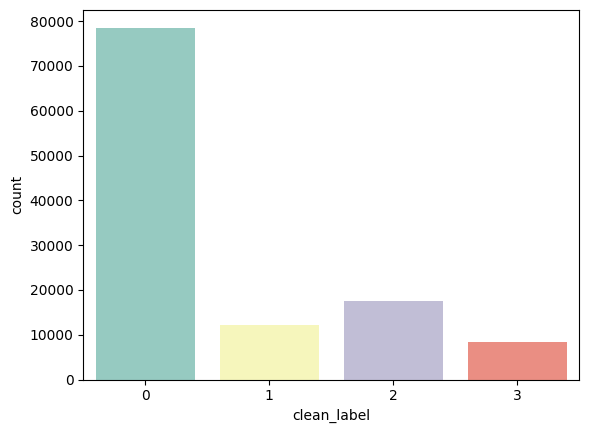

In [59]:
sns.countplot(x='clean_label', palette="Set3", data=total_train[0])

## feature density  

In [62]:
import math

In [67]:
def plot_feature_distribution(df0, df1, df2, df3, label0, label1, label2, label3, features):
    feature_len = len(features)
    plt_size = math.ceil(math.sqrt(feature_len))
    
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(plt_size,plt_size,figsize=(18,22))
    fig.subplots_adjust(wspace=0.5, hspace=0.5) # 서브플롯 간의 간격 조정

    for feature in features:
        i += 1
        plt.subplot(plt_size,plt_size,i)
        sns.distplot(df0[feature], hist=False,label=label0)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        sns.distplot(df3[feature], hist=False,label=label3)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
        plt.legend(labels=[label0, label1, label2, label3])
    plt.show();

<Figure size 640x480 with 0 Axes>

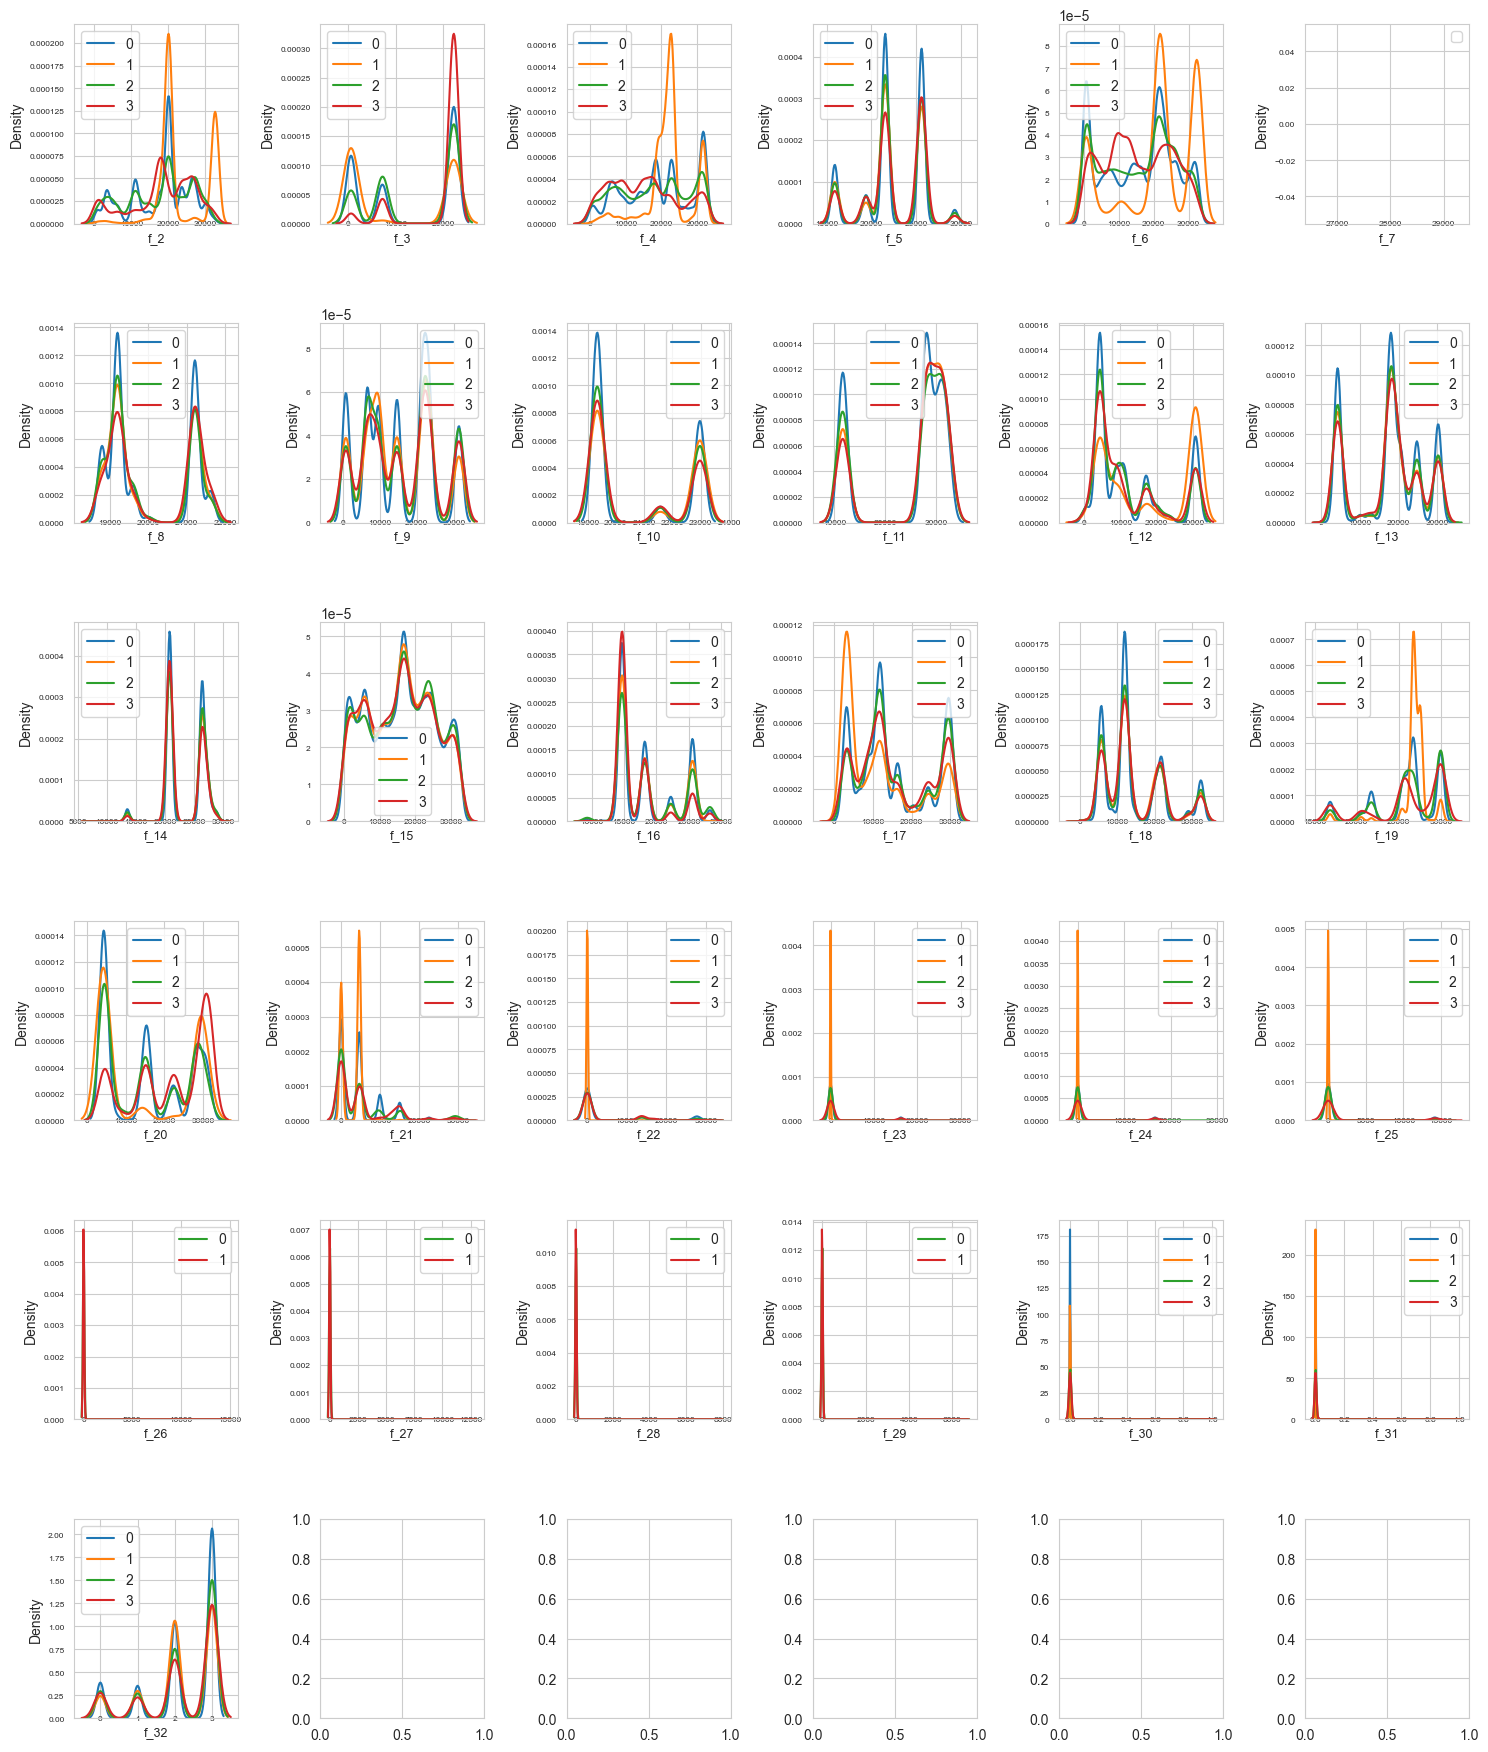

In [69]:
df0 = total_train[0].loc[total_train[0]['clean_label']==0]
df1 = total_train[0].loc[total_train[0]['clean_label']==1]
df2 = total_train[0].loc[total_train[0]['clean_label']==2]
df3 = total_train[0].loc[total_train[0]['clean_label']==3]
plot_feature_distribution(df0, df1, df2, df3, "0", "1", "2", "3", categorical_cols)

<Figure size 640x480 with 0 Axes>

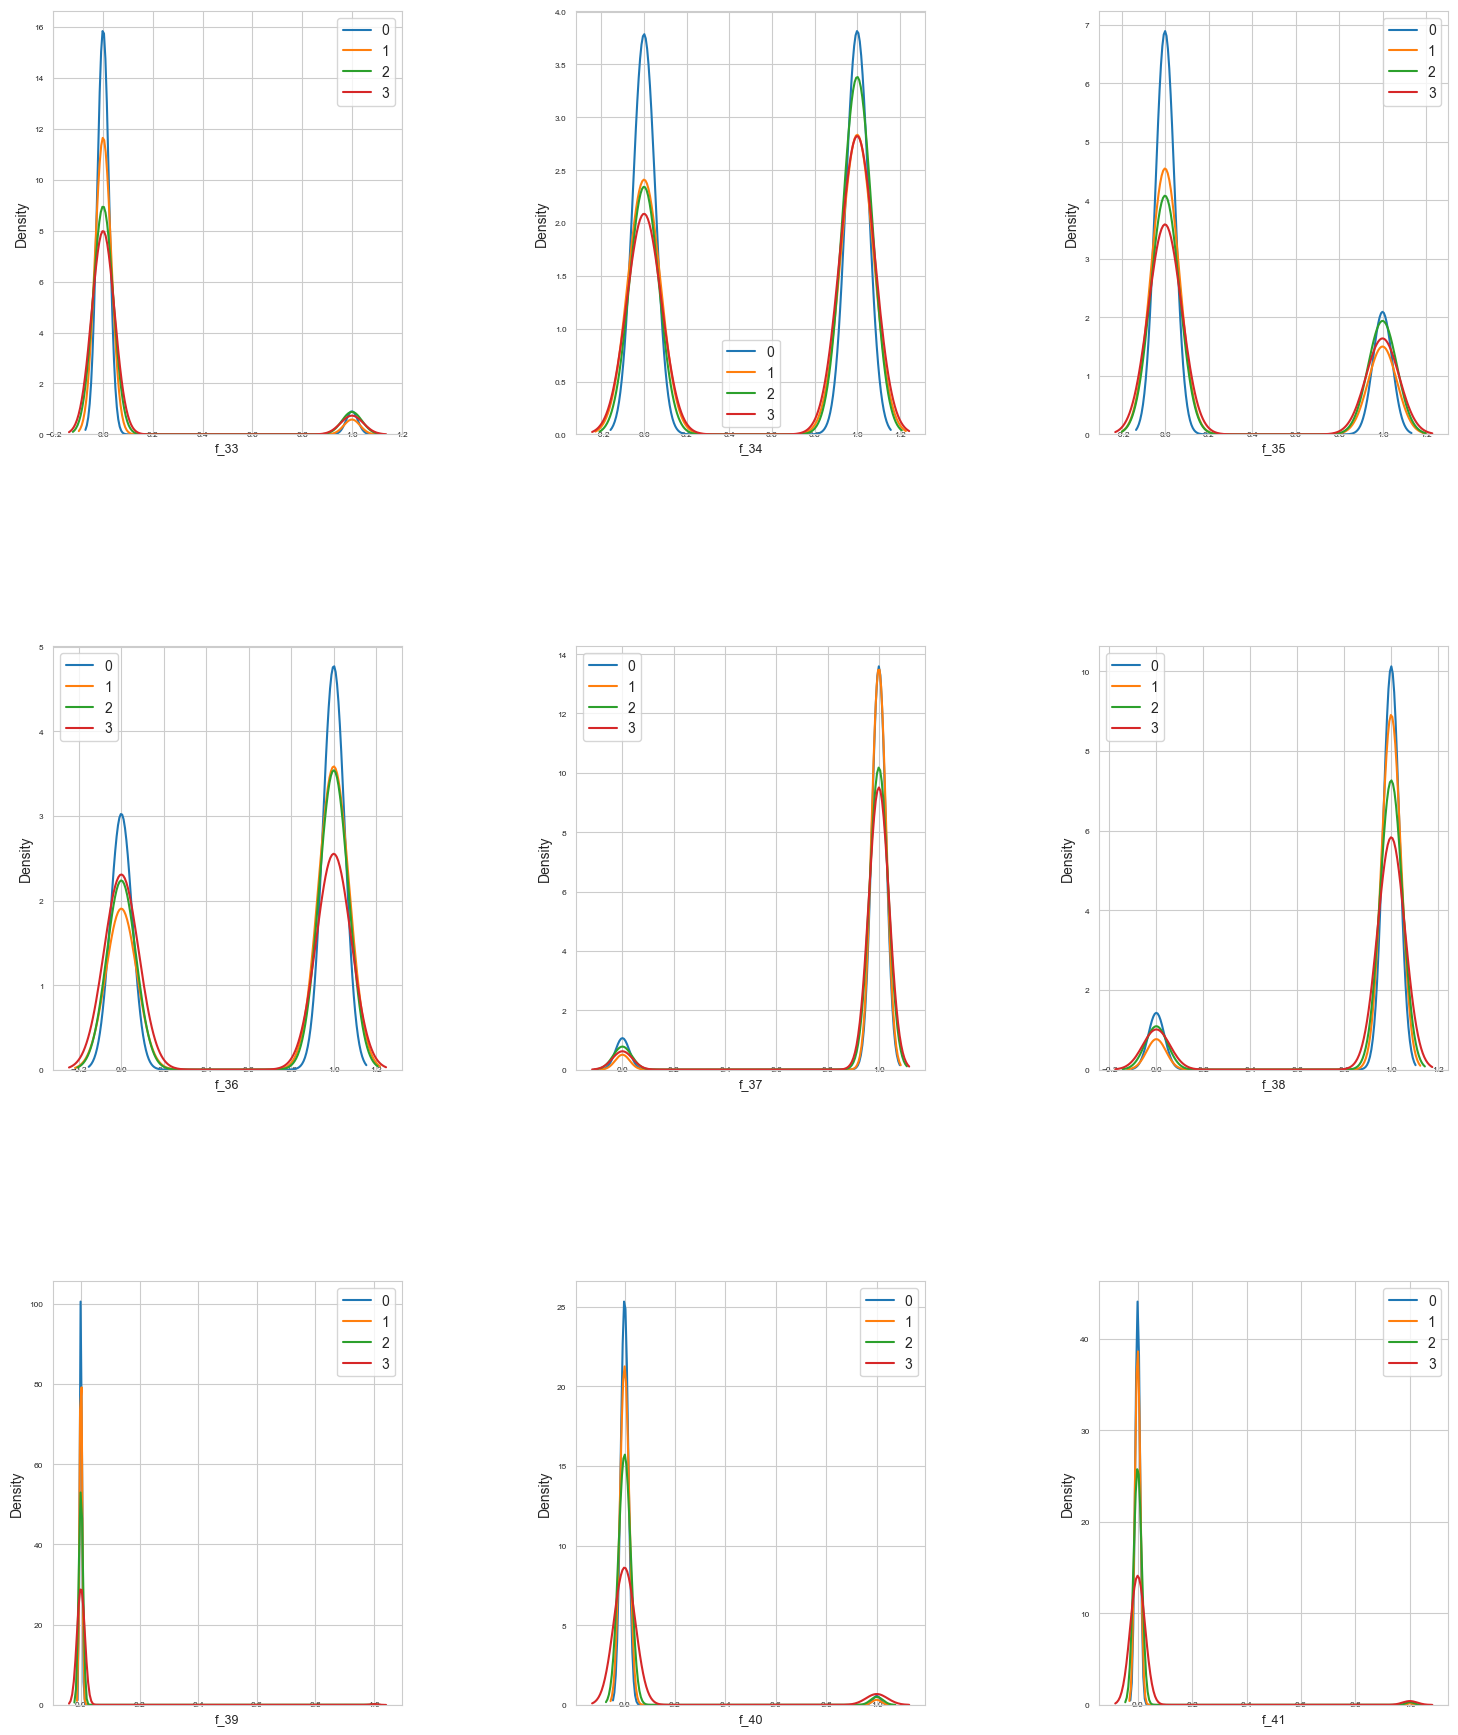

In [68]:
plot_feature_distribution(df0, df1, df2, df3, "0", "1", "2", "3", binary_cols)

<Figure size 640x480 with 0 Axes>

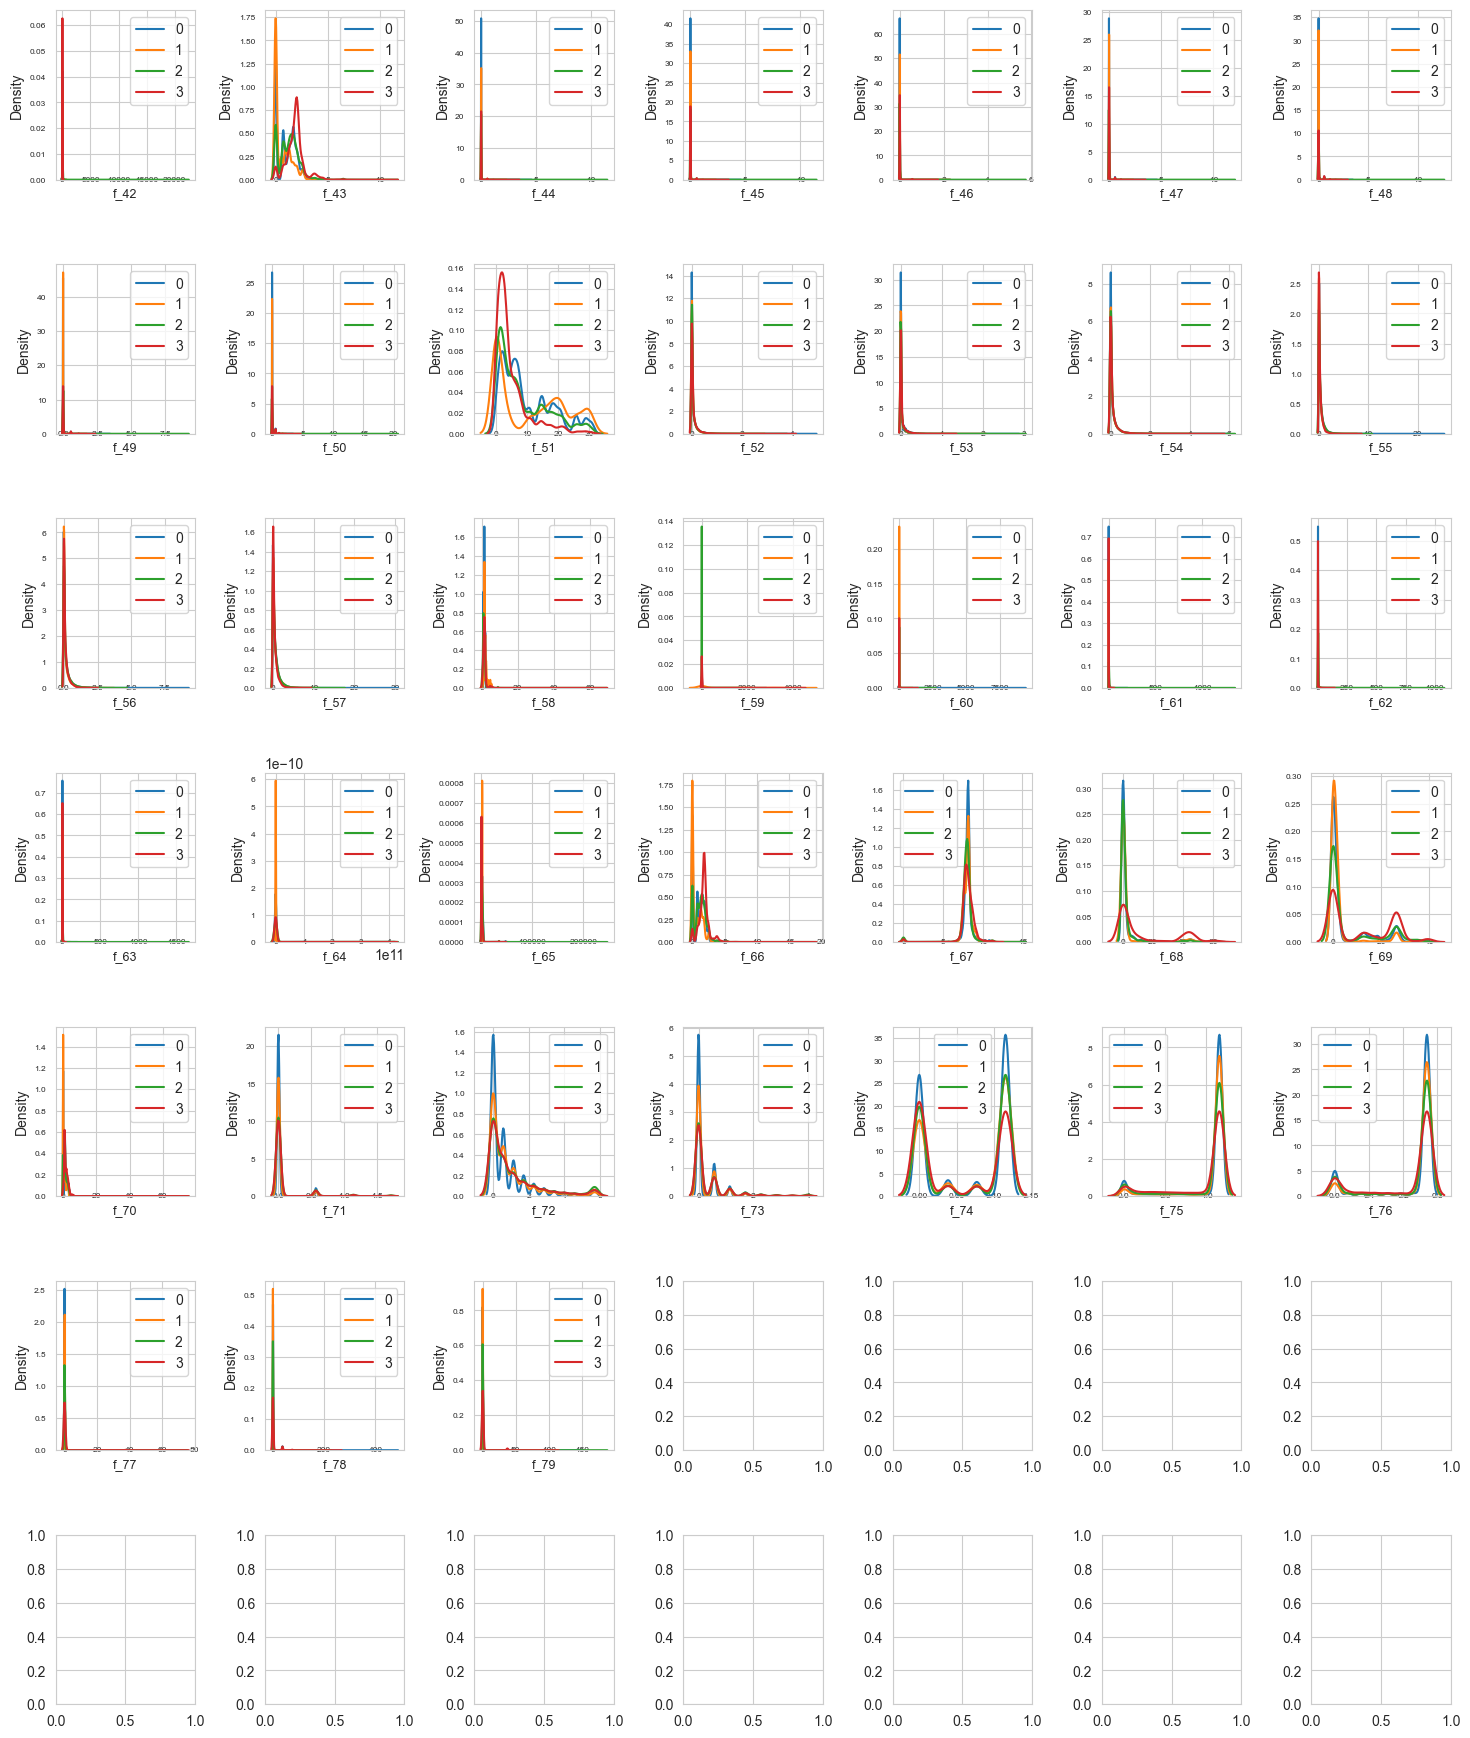

In [70]:
plot_feature_distribution(df0, df1, df2, df3, "0", "1", "2", "3", numerical_cols)